In [1]:
import numpy as np
import pandas as pd

In [2]:
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, GlobalAveragePooling1D, Lambda, Bidirectional
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, RMSprop
from keras import backend as K

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
import keras 
keras.__version__

'2.2.2'

In [4]:
#open .npy files in read mode in the binary format and load
q1_data = np.load(open('q1_train.npy', 'rb'))
q2_data = np.load(open('q2_train.npy', 'rb'))

labels = np.load(open('label_train.npy', 'rb'))
embedding_matrix = np.load(open('word_embedding_matrix.npy', 'rb'))

In [5]:
from sklearn.cross_validation import train_test_split

#joining the numpy array containing the question series along the 2nd dimension (y)
X = np.stack((q1_data, q2_data), axis=1)
target = labels

#X contains the stacked input columns and target contains the is_duplicate flag values 
#training happens on 75% of the training dataset, train.csv and validation happens on the remaining 25%
#stratify - generate samples that represent the dataset effectively - applied on target
#random_state = a number (any) => results can be reproduced since only one particular state is taken into consideration
X_train, X_val, y_train, y_val = train_test_split(X, target, test_size=0.25, random_state=126, stratify=target)
Q1_train = X_train[:,0]
Q2_train = X_train[:,1]
Q1_val = X_val[:,0]
Q2_val = X_val[:,1]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [6]:
#returns the sum of the square of the differences in weights
def vec_distance(vects):
    x, y = vects
    return K.sum(K.square(x - y), axis=1, keepdims=True)

In [7]:
#returns the shape of the output vector
def vec_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [8]:
from keras.layers.embeddings import Embedding

#create the custom embedding layer
#length of the GLoVe file
nb_words = 137043
#same as that specified during padding
max_sentence_len=25
#shape = 137043 x 300, weights contains the embedding matrix created
#trainable = False => to exclude it from training or to freeze the layer so as to ensure fixed embedding for input text
embedding_layer = Embedding(nb_words, 300, weights=[embedding_matrix], input_length=max_sentence_len, trainable=False)

In [9]:
#Long Short Term Memory layer with 128 units (dimensionality of the output space), default activation function - tanh
lstm_layer =LSTM(128)

#to initiate a Keras tensor, tensor object from the underlying backend (Theano, TensorFlow or CNTK), which we augment with certain attributes that allow us to build a Keras model just by knowing the inputs and outputs of the model
sequence_1_input = Input(shape=(max_sentence_len,), dtype='int32')
#create embedding layer with Keras tensor object as input 
embedded_sequences_1 = embedding_layer(sequence_1_input)
#create LSTM layer with the embedded sequence as input
x1 = lstm_layer(embedded_sequences_1)

sequence_2_input = Input(shape=(max_sentence_len,), dtype='int32')
embedded_sequences_2 = embedding_layer(sequence_2_input)
y1 = lstm_layer(embedded_sequences_2)

#lambda function performs the functionality defined by the function/method passed to it as argument (here, vec_distance)
distance=Lambda(vec_distance, output_shape=vec_output_shape)([x1, y1])
#dense layer is a densely connected NN layer
#performs linear operations
#in order to facilitate non linear operations, use activation functions
#sigmoid function converts numbers in the range [0, 1]
dense1=Dense(16, activation='sigmoid')(distance)
#dropout layer is used to prevent overfitting of the model
dense1 = Dropout(0.3)(dense1)

#batch normalization is used to speed up learning
#when we have features from 0 to 1 and some from 1 to 1000, we should normalize them to speed up learning
#applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1
bn2 = BatchNormalization()(dense1)
prediction=Dense(1, activation='sigmoid')(bn2)

#create the model
model = Model(inputs=[sequence_1_input, sequence_2_input], outputs=prediction)

In [10]:
#detailed summary of the model architecture
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 25)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 25)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 25, 300)      41112900    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 128)          219648      embedding_1[0][0]                
          

In [11]:
#complile the model using loss - binary cross entropy (convention for binary classifier) and Adam optimizer, performance metrics is accuracy
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [12]:
#callback function that stops the training when the loss value decreases continously for 3 epochs
early_stopping =EarlyStopping(monitor='val_loss', patience=3)

In [13]:
#fit the model onto the data using which it should be trained
#trained for 10 epochs (only 7 execute as a result of early stopping)
#batch size of 256 
#no shuffling
#callback used early stopping
hist=model.fit([Q1_train, Q2_train], y_train, validation_data=([Q1_val, Q2_val], y_val), verbose=1, epochs=10, batch_size=256, shuffle=False, class_weight=None, callbacks=[early_stopping])

Train on 303217 samples, validate on 101073 samples
Epoch 1/10
303217/303217 [==============================] - 258s 851us/step - loss: 0.5196 - acc: 0.7409 - val_loss: 0.4297 - val_acc: 0.8014
Epoch 2/10
303217/303217 [==============================] - 256s 843us/step - loss: 0.4213 - acc: 0.8069 - val_loss: 0.3984 - val_acc: 0.8187
Epoch 3/10
303217/303217 [==============================] - 257s 846us/step - loss: 0.3808 - acc: 0.8310 - val_loss: 0.3857 - val_acc: 0.8273
Epoch 4/10
303217/303217 [==============================] - 257s 847us/step - loss: 0.3524 - acc: 0.8471 - val_loss: 0.3820 - val_acc: 0.8325
Epoch 5/10
303217/303217 [==============================] - 255s 841us/step - loss: 0.3296 - acc: 0.8594 - val_loss: 0.3813 - val_acc: 0.8349
Epoch 6/10
303217/303217 [==============================] - 255s 841us/step - loss: 0.3094 - acc: 0.8695 - val_loss: 0.3836 - val_acc: 0.8362
Epoch 7/10
303217/303217 [==============================] - 256s 843us/step - loss: 0.2907 - acc

In [14]:
#save the model in a HDF5 file
#used to store the trained model
#an HDF5 file is a container for two kinds of objects: datasets, which are array-like collections of data, and groups, which are folder-like containers that hold datasets and other groups
#groups work like dictionaries, and datasets work like NumPy arrays
model.save('my_model.h5')

In [15]:
test1_data = np.load(open('test1.npy', 'rb')) 
test2_data = np.load(open('test2.npy', 'rb'))

#predict the values using the test data
prediction = model.predict([test1_data, test2_data], verbose=1)

3563475/3563475 [==============================] - 1719s 482us/step


In [16]:
#converting similarity value to a class (similar[1]/ not similar[0])
rounded_prediction = [round(x[0]) for x in prediction]

In [17]:
#Accuracy
import matplotlib.pyplot as plt
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('Accuracy.png')
plt.show()

<Figure size 640x480 with 1 Axes>

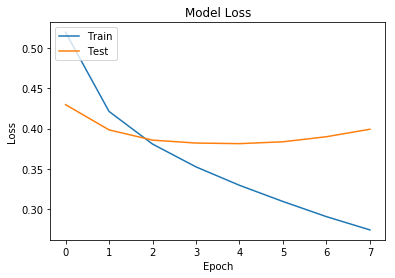

In [18]:
#loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('Loss.png')
plt.show()

In [10]:
#RUN THIS EVERYTIME
#retrieve the variables stored in Preprocessing.ipynb (word_index) and POS_tagged_approach.ipynb (question and result) respectively 
%store -r word_index
%store -r question
%store -r result

In [11]:
#RUN THIS EVERYTIME
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model

def preprocess(ques):
    str(ques)
    ques = ques.lower()
    ques = str.replace(ques, '?', '')
    ques = str.replace(ques, ',', '')
    ques = str.replace(ques, '(', '')
    ques = str.replace(ques, ')', '')
    ques = str.replace(ques, '"', '')
    return ques

def execute_similar():
    count = 0
    model = load_model('my_model.h5')
    q1 = question
    q1 = preprocess(q1)
    q1 = [word_index[word] for word in q1.split()]
    q1 = pad_sequences([q1], maxlen=25, padding='post')
    for res in result:
        q2 = res
        q = q2
        q2 = preprocess(q2) 
        q2 = [word_index[word] for word in q2.split()]
        q2 = pad_sequences([q2], maxlen=25, padding='post')
        val = model.predict([q1, q2], verbose=0)
        sim = 'Similar' if int(round(val[0][0])) == 1 else 'Not Similar'
        if sim == 'Similar':
            print(q)    
            count = count + 1
    if count == 0:
        print("Sorry! There are no similar questions.")

In [12]:
execute_similar()

Sorry! There are no similar questions.
